In [2]:
import pandas as pd
import requests
import pip


if int(pip.__version__.split('.')[0])>9:
     from pip._internal import main
else:
     from pip import main
def install(package):
     main(['install', package])

install('BeautifulSoup4')


# The code below is for loading the table from Wikipedia for Toronto neighborhood, and give BeautifulSoup a try

In [4]:
#!python --version
!conda install tqdm --yes
!conda install -c anaconda lxml --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.1.1   |                0         125 KB
    certifi-2020.4.5.1         |           py36_0         155 KB
    openssl-1.1.1g             |       h7b6447c_0         2.5 MB
    ------------------------------------------------------------
                                           Total:         2.8 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates                                  anaconda --> pkgs/main
  certifi                                          anaconda --> pkgs/main
  openssl                                          anaconda --> pkgs/main



ca-certificates-2020 | 125 KB    | ##################################### | 100% 
openss

In [5]:
from bs4 import BeautifulSoup
from lxml import etree


In [6]:
req = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(req.content,'lxml')

table = soup.find_all('table')[0]
df = pd.read_html(str(table))
neighborhood=pd.DataFrame(df[0])
neighborhood.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [7]:
neighborhood = neighborhood[neighborhood['Borough']!='Not assigned']
neighborhood.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


# The above lines are used to remove the 'Not assinged' lines, and the line below shows dimension of the dataframe

In [8]:
neighborhood.shape

(103, 3)

# The part below reads the latitude/longitude data and merge it with the dataframe above to create a new dataframe

In [9]:
GeoData_df=pd.read_csv("http://cocl.us/Geospatial_data")
GeoData_df.shape

(103, 3)

In [10]:
GeoData_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


# The line below merges two dataframe together to a new dataframe

In [20]:
Trt_df = pd.merge(GeoData_df, neighborhood, on='Postal Code')
Trt_df.head()

,Postal Code,Latitude,Longitude,Borough,Neighborhood
0,M1B,43.806686,-79.194353,Scarborough,"Malvern, Rouge"
1,M1C,43.784535,-79.160497,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,43.770992,-79.216917,Scarborough,Woburn
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae


In [21]:
Trt_df.shape

(103, 5)

In [22]:
#double check no more 'Not Assigned'
Trt_df.isin(['Not Assigned']).any()

Postal Code     False
Latitude        False
Longitude       False
Borough         False
Neighborhood    False
dtype: bool

# The part below clusters the boroughs to four new clusters based on the distances between them and then visualizes the resulting clusters on the map

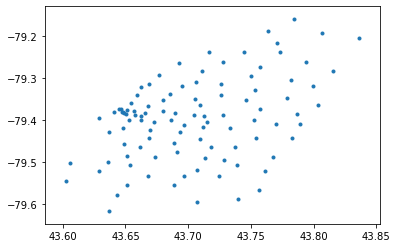

In [23]:
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 

plt.scatter(Trt_df['Latitude'], Trt_df['Longitude'], marker='.')

In [24]:
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)
X = Trt_df[['Latitude', 'Longitude']]
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
k_means_labels = k_means.labels_
k_means_labels
# add clustering labels
Trt_df.insert(0, 'Cluster Labels', k_means_labels)
Trt_df.head()

,Cluster Labels,Postal Code,Latitude,Longitude,Borough,Neighborhood
0,0,M1B,43.806686,-79.194353,Scarborough,"Malvern, Rouge"
1,0,M1C,43.784535,-79.160497,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,0,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"
3,0,M1G,43.770992,-79.216917,Scarborough,Woburn
4,0,M1H,43.773136,-79.239476,Scarborough,Cedarbrae


In [26]:
import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[43.6, -79.3], zoom_start=11)

kclusters = 4

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Trt_df['Latitude'], Trt_df['Longitude'], Trt_df['Borough'], Trt_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters
